In [1]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Dropout,Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

In [10]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [12]:
! cp kaggle.json ~/.kaggle/

In [13]:
! chmod 600 ~/.kaggle/kaggle.json

In [14]:
!kaggle datasets download -d msambare/fer2013

 96% 58.0M/60.3M [00:03<00:00, 24.9MB/s]
100% 60.3M/60.3M [00:03<00:00, 18.1MB/s]


In [ ]:
! unzip /content/fer2013.zip

In [16]:
train_data_gen=ImageDataGenerator(rescale=1./255)
validation_data_gen=ImageDataGenerator(rescale=1./255)

In [17]:
train_generator=train_data_gen.flow_from_directory(
    'train',
    target_size=(48,48),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical'
)
validation_generator=validation_data_gen.flow_from_directory(
    'test',
    target_size=(48,48),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [18]:
emotion_model=Sequential()

emotion_model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(48,48,1)))
emotion_model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2,2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2,2)))
emotion_model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2,2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Flatten())
emotion_model.add(Dense(1024,activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(7,activation='softmax'))

emotion_model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001,decay=1e-6),metrics=['accuracy'])



/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [21]:
emotion_model_info=emotion_model.fit_generator(
    train_generator,
    steps_per_epoch=28709//64,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=7178//64
)

Epoch 1/20
  3/448 [..............................] - ETA: 14s - loss: 1.1246 - accuracy: 0.5625

<ipython-input-21-b7c89545c2d2>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  emotion_model_info=emotion_model.fit_generator(


448/448 [==============================] - 19s 42ms/step - loss: 1.2915 - accuracy: 0.5119 - val_loss: 1.2744 - val_accuracy: 0.5152
Epoch 2/20
448/448 [==============================] - 16s 36ms/step - loss: 1.2653 - accuracy: 0.5224 - val_loss: 1.2487 - val_accuracy: 0.5278
Epoch 3/20
448/448 [==============================] - 19s 42ms/step - loss: 1.2446 - accuracy: 0.5314 - val_loss: 1.2318 - val_accuracy: 0.5262
Epoch 4/20
448/448 [==============================] - 19s 42ms/step - loss: 1.2208 - accuracy: 0.5377 - val_loss: 1.2129 - val_accuracy: 0.5363
Epoch 5/20
448/448 [==============================] - 25s 56ms/step - loss: 1.2034 - accuracy: 0.5419 - val_loss: 1.2155 - val_accuracy: 0.5324
Epoch 6/20
448/448 [==============================] - 24s 52ms/step - loss: 1.1904 - accuracy: 0.5516 - val_loss: 1.1911 - val_accuracy: 0.5466
Epoch 7/20
448/448 [==============================] - 16s 36ms/step - loss: 1.1687 - accuracy: 0.5629 - val_loss: 1.1775 - val_accuracy: 0.5519
Epo

In [22]:
model_json=emotion_model.to_json()
with open('emotion_model.json','w') as json_file:
  json_file.write(model_json)

emotion_model.save_weights('emotion_model.h5')

In [8]:
import cv2
import numpy as np
from keras.models import model_from_json
import matplotlib.pyplot as plt

In [2]:
emotion_dict={0:'Angry',1:'Disgusted',2:'Fearful',3:'Happy',4:'Neutral',5:'Sad',6:'Surprised'}

In [3]:
json_file=open('emotion_model.json','r')
loaded_model_json=json_file.read()
json_file.close()
emotion_model=model_from_json(loaded_model_json)
print(emotion_model)

In [5]:
emotion_model.load_weights('emotion_model.h5')

1/1 [==============================] - 0s 24ms/step
Happy


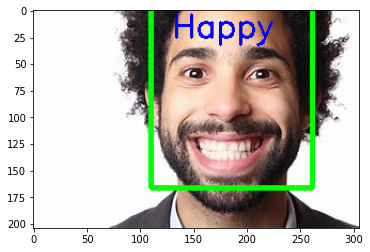

In [9]:
frame=cv2.imread('/content/th.jfif')
face_detector=cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')
gray_frame=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)

num_faces=face_detector.detectMultiScale(gray_frame,scaleFactor=1.3,minNeighbors=5)
for (x,y,w,h) in num_faces:
  cv2.rectangle(frame,(x,y-50),(x+w,y+h+10),(0,255,0),4)
  roi_gray_frame=gray_frame[y:y+h,x:x+h]
  cropped_img=np.expand_dims(np.expand_dims(cv2.resize(roi_gray_frame,(48,48)),-1),0)

  emotion_prediction=emotion_model.predict(cropped_img)
  maxindex=int(np.argmax(emotion_prediction))
  print(emotion_dict[maxindex])
  cv2.putText(frame,emotion_dict[maxindex],(x+20,y+20),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0),2,cv2.LINE_8)

plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))